In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
tf.reset_default_graph()
from tensorflow.examples.tutorials.mnist import input_data

mnist = input_data.read_data_sets("MNIST_data/", one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


In [3]:
import os

logs_path = os.path.join(os.getcwd(), '2d_mnist_dnn_tensorboard')

In [4]:
with tf.name_scope("input"):
    input_images = tf.placeholder(tf.float32, shape=[None, mnist.train.images.shape[1]], name='input_images')
    input_labels = tf.placeholder(tf.float32, shape=[None, mnist.train.labels.shape[1]], name='input_labels')

print(input_images.shape)
print(input_labels.shape)

(?, 784)
(?, 10)


In [5]:
hidden_units = 768
with tf.name_scope("weights"):
    input_weights = tf.Variable(tf.random_normal([int(input_images.shape[1]), hidden_units]), name='input_weights')

with tf.name_scope("biases"):
    input_biases = tf.Variable(tf.constant(0.1, shape=[hidden_units]), name='input_biases') # can avoid dead neuros by adding initial bias

In [6]:
with tf.name_scope("hidden_layer_wb"):
    hidden_weights = tf.Variable(tf.random_normal([hidden_units, 10]), name='hidden_weights')
    hidden_biases = tf.Variable(tf.constant(0.1, shape=[10]), name='hidden_biases')

with tf.name_scope("hidden_layer_cau"):
    input_layer = tf.matmul(input_images, input_weights) + input_biases
    input_dropout = tf.nn.dropout(input_layer, 0.5)
    input_active = tf.nn.relu(input_layer)

    logits = tf.matmul(input_active, hidden_weights) + hidden_biases

In [7]:
with tf.name_scope("cost"):
    loss_function = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=input_labels))

In [8]:
with tf.name_scope("train"):
    optimizer = tf.train.GradientDescentOptimizer(0.4).minimize(loss_function)

In [9]:
with tf.name_scope("accuracy"):
    correct_prediction = tf.equal(tf.argmax(logits, axis=1), tf.argmax(input_labels,axis=1))
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [10]:
tf.summary.scalar("cost", loss_function)
tf.summary.scalar("accuracy", accuracy)
# command line for tensorboard $tensorboard --logdir=train:`logs_path`/train,test:`logs_path`/test --port 6006
# merge all summaries into a single "operation" which can execute in a session
summary_all = tf.summary.merge_all()

In [11]:
def save_model(sess, saver, model_name="model", global_step=None):
    """
    Save current model into ./models folder
    """
    suffix = 'meta'
    with sess.as_default():
        
        import os
        model_path = os.path.join(os.getcwd(), 'models')
        model_fqn = os.path.join(model_path, model_name + '-' + str(global_step))
        
        saver.save(sess, model_fqn, meta_graph_suffix=suffix)
        
        saver.export_meta_graph(filename=model_fqn + "." + suffix)

In [12]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

# create training logs for tensorflow
train_writer = tf.summary.FileWriter(os.path.join(logs_path, 'train'), graph=tf.get_default_graph())
test_writer = tf.summary.FileWriter(os.path.join(logs_path, 'test'), graph=tf.get_default_graph())

with sess.as_default():
    
    for i in range(3):
        print("Epoch", i+1)
        for x in range(int(mnist.train.num_examples/128)+1):
            batch = mnist.train.next_batch(128)
            _, train_sum = sess.run([optimizer, summary_all], feed_dict={input_images: batch[0], input_labels: batch[1]})
            if ((x+1) % 100 == 0):
                print("\tTraining batch " + str(x+1), end='')
                ac, test_sum = sess.run([accuracy, summary_all], feed_dict={input_images: mnist.test.images, input_labels: mnist.test.labels})
                print(" Accuracy: " + str(ac))
                train_writer.add_summary(train_sum, i*(int(mnist.train.num_examples/128)+1)+x+1)
                test_writer.add_summary(test_sum, i*(int(mnist.train.num_examples/128)+1)+x+1)
                train_writer.flush()
                test_writer.flush()
                
    
                saver = tf.train.Saver()
                save_model(sess, saver, global_step=i*(int(mnist.train.num_examples/128)+1)+x+1)
       
    train_writer.close()
    test_writer.close()
    
sess.close()

Epoch 1
	Training batch 100 Accuracy: 0.8851
	Training batch 200 Accuracy: 0.9033
	Training batch 300 Accuracy: 0.9107
	Training batch 400 Accuracy: 0.9169
Epoch 2
	Training batch 100 Accuracy: 0.9243
	Training batch 200 Accuracy: 0.9256
	Training batch 300 Accuracy: 0.9279
	Training batch 400 Accuracy: 0.9287
Epoch 3
	Training batch 100 Accuracy: 0.9332
	Training batch 200 Accuracy: 0.9337
	Training batch 300 Accuracy: 0.9329
	Training batch 400 Accuracy: 0.9355


In [33]:
new_graph = tf.Graph()
with tf.Session(graph=new_graph) as sess:
    import os
    model_fqn = os.path.join(os.getcwd(), 'models', 'model-730')
    saver = tf.train.import_meta_graph(model_fqn + ".meta")
    saver.restore(sess, model_fqn)
    # Initalize the variables
    sess.run(tf.global_variables_initializer())

    # Get default graph (supply your custom graph if you have one)
    graph = tf.get_default_graph()
#     print([n.name for n in tf.get_default_graph().as_graph_def().node])
    # It will give tensor object
    W1 = graph.get_tensor_by_name('input/input_images:0')

    # To get the value (numpy array)
    W1_value = sess.run(W1)
    
    print(W1_value)
#     for step in xrange(1000000):
#         sess.run(train_op)

InvalidArgumentError: You must feed a value for placeholder tensor 'input/input_images' with dtype float
	 [[Node: input/input_images = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'input/input_images', defined at:
  File "/Users/shijian/anaconda3/lib/python3.5/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/Users/shijian/anaconda3/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/Users/shijian/anaconda3/lib/python3.5/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/Users/shijian/anaconda3/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/Users/shijian/anaconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 477, in start
    ioloop.IOLoop.instance().start()
  File "/Users/shijian/anaconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/Users/shijian/anaconda3/lib/python3.5/site-packages/tornado/ioloop.py", line 888, in start
    handler_func(fd_obj, events)
  File "/Users/shijian/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/shijian/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/Users/shijian/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/Users/shijian/anaconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/Users/shijian/anaconda3/lib/python3.5/site-packages/tornado/stack_context.py", line 277, in null_wrapper
    return fn(*args, **kwargs)
  File "/Users/shijian/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/Users/shijian/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 235, in dispatch_shell
    handler(stream, idents, msg)
  File "/Users/shijian/anaconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/Users/shijian/anaconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/Users/shijian/anaconda3/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 533, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/Users/shijian/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2698, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/Users/shijian/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2802, in run_ast_nodes
    if self.run_code(code, result):
  File "/Users/shijian/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2862, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-33-46796851fef5>", line 5, in <module>
    saver = tf.train.import_meta_graph(model_fqn + ".meta")
  File "/Users/shijian/anaconda3/lib/python3.5/site-packages/tensorflow/python/training/saver.py", line 1577, in import_meta_graph
    **kwargs)
  File "/Users/shijian/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/meta_graph.py", line 498, in import_scoped_meta_graph
    producer_op_list=producer_op_list)
  File "/Users/shijian/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/importer.py", line 287, in import_graph_def
    op_def=op_def)
  File "/Users/shijian/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2395, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/Users/shijian/anaconda3/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1264, in __init__
    self._traceback = _extract_stack()

InvalidArgumentError (see above for traceback): You must feed a value for placeholder tensor 'input/input_images' with dtype float
	 [[Node: input/input_images = Placeholder[dtype=DT_FLOAT, shape=[], _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [39]:
# start up tensorboard using $ tensorboard --logdir=/Users/shijian/git/3D-CNN/2d_mnist_dnn_tensorboard/ --port 6006
# To see if the summary writer works well
for i in tf.train.summary_iterator(logs_path + '/events.out.tfevents.1508854176.host-163-117.eduroam-local.wifi.le.ac.uk'):
    print(i)

wall_time: 1508854176.0
file_version: "brain.Event:2"

wall_time: 1508854176.992708
graph_def: "\nd\n\021input/Placeholder\022\013Placeholder*(\n\016_output_shapes\022\026\n\024:\022\022\013\010\377\377\377\377\377\377\377\377\377\001\022\003\010\220\006*\013\n\005shape\022\002:\000*\013\n\005dtype\022\0020\001\ne\n\023input/Placeholder_1\022\013Placeholder*\'\n\016_output_shapes\022\025\n\023:\021\022\013\010\377\377\377\377\377\377\377\377\377\001\022\002\010\n*\013\n\005shape\022\002:\000*\013\n\005dtype\022\0020\001\nl\n\033weights/random_normal/shape\022\005Const*\032\n\016_output_shapes\022\010\n\006:\004\022\002\010\002*\035\n\005value\022\024B\022\010\003\022\004\022\002\010\002\"\010\020\003\000\000\000\003\000\000*\013\n\005dtype\022\0020\003\n_\n\032weights/random_normal/mean\022\005Const*\026\n\016_output_shapes\022\004\n\002:\000*\025\n\005value\022\014B\n\010\001\022\000*\004\000\000\000\000*\013\n\005dtype\022\0020\001\na\n\034weights/random_normal/stddev\022\005Const*\0

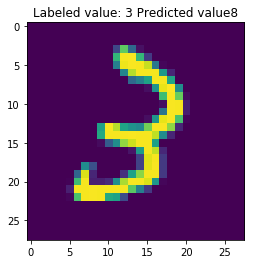

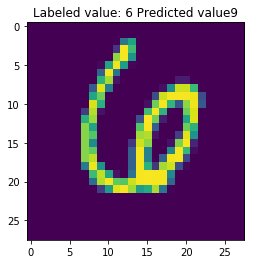

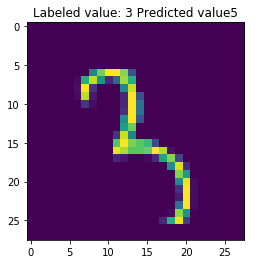

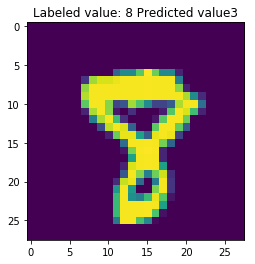

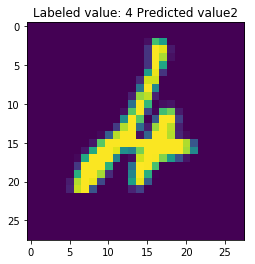

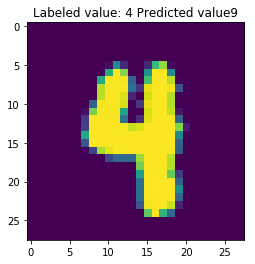

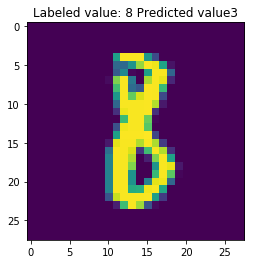

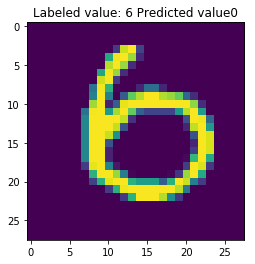

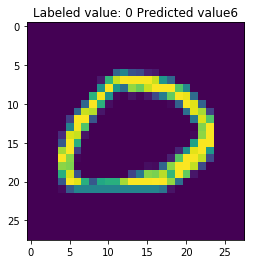

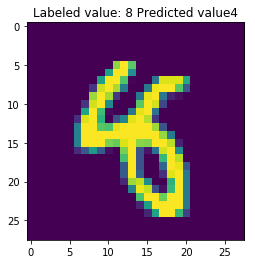

In [24]:
import numpy as np
with sess.as_default():
    for i in range(300):
        acc, res = sess.run([correct_prediction, logits], feed_dict={input_images: mnist.test.images[i: i+1], input_labels: mnist.test.labels[i:i+1]})
        if acc == False:
            fig = plt.figure()
            ax = fig.add_subplot()
            plt.title("Labeled value: "+ str(np.argmax(mnist.test.labels[i:i+1])) + " Predicted value"+ str(np.argmax(res)))
            plt.imshow(mnist.test.images[i:i+1].reshape([28, 28]))

# CNN

In [3]:
def weight_variable(shape):
  initial = tf.truncated_normal(shape, stddev=0.1, seed=1)
  return tf.Variable(initial)

def bias_variable(shape):
  initial = tf.constant(0.1, shape=shape)
  return tf.Variable(initial)

def conv2d(x, W):
  return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='SAME')

def max_pool_2x2(x):
  return tf.nn.max_pool(x, ksize=[1, 2, 2, 1],
                        strides=[1, 2, 2, 1], padding='SAME')

In [4]:
input_images = tf.placeholder(tf.float32, shape=[None, mnist.train.images.shape[1]])
input_labels = tf.placeholder(tf.float32, shape=[None, mnist.train.labels.shape[1]])

In [5]:
W_conv1 = weight_variable([5, 5, 1, 32])
b_conv1 = bias_variable([32])

x_image = tf.reshape(input_images, [-1, 28, 28, 1])

h_conv1 = tf.nn.relu(conv2d(x_image, W_conv1) + b_conv1)
h_pool1 = max_pool_2x2(h_conv1)

In [6]:
W_conv2 = weight_variable([5, 5, 32, 64])
b_conv2 = bias_variable([64])

h_conv2 = tf.nn.relu(conv2d(h_pool1, W_conv2) + b_conv2)
h_pool2 = max_pool_2x2(h_conv2)

In [7]:
W_conv3 = weight_variable([5, 5, 64, 128])
b_conv3 = bias_variable([128])

h_conv3 = tf.nn.relu(conv2d(h_pool2, W_conv3) + b_conv3)
h_pool3 = max_pool_2x2(h_conv3)

In [8]:
# W_fc1 = weight_variable([4 * 4 * 128, 1024])
# b_fc1 = bias_variable([1024])
# h_pool2_flat = tf.reshape(h_pool3, [-1, 4*4*128])

W_fc1 = weight_variable([7 * 7 * 64, 1024])
b_fc1 = bias_variable([1024])
h_pool2_flat = tf.reshape(h_pool2, [-1, 7*7*64])

h_fc1 = tf.nn.relu(tf.matmul(h_pool2_flat, W_fc1) + b_fc1)

In [9]:
keep_prob = tf.placeholder(tf.float32)
h_fc1_drop = tf.nn.dropout(h_fc1, keep_prob)

In [10]:
W_fc2 = weight_variable([1024, 10])
b_fc2 = bias_variable([10])

y_conv = tf.matmul(h_fc1_drop, W_fc2) + b_fc2

In [11]:
cross_entropy = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=input_labels, logits=y_conv))
train_step = tf.train.AdamOptimizer(1e-4).minimize(cross_entropy)

correct_prediction = tf.equal(tf.argmax(y_conv, axis=1), tf.argmax(input_labels, axis=1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [12]:
import os

logs_path = os.path.join(os.getcwd(), '2d_mnist_cnn_tensorboard')

tf.summary.scalar("cross_entropy", cross_entropy)
tf.summary.scalar("accuracy", accuracy)
# command line for tensorboard $tensorboard --logdir=train:`logs_path`/train,test:`logs_path`/test --port 6006
# merge all summaries into a single "operation" which can execute in a session
summary_all = tf.summary.merge_all()

In [18]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())

epochs = 5
batch_size = 128

dil = 100

train_writer = tf.summary.FileWriter(os.path.join(logs_path, 'train'), graph=tf.get_default_graph())
test_writer = tf.summary.FileWriter(os.path.join(logs_path, 'test'), graph=tf.get_default_graph())

with sess.as_default():
    count = 0
    sess.run(tf.global_variables_initializer())
    for i in range(epochs):
        print("Epoch", i+1)
        for x in range(int(mnist.train.num_examples/batch_size)+1):
            batch = mnist.train.next_batch(batch_size)
            _, train_sum = sess.run([train_step, summary_all], feed_dict={input_images: batch[0], input_labels: batch[1], keep_prob: 0.5})
            if x % dil == 0:
                print("\tTraining batch " + str(x+1), end='')
                ac, test_sum = sess.run([accuracy, summary_all], feed_dict={input_images: mnist.test.images, input_labels: mnist.test.labels, keep_prob: 1.0})
                print(" Accuracy: " + str(ac))
                train_writer.add_summary(train_sum, count)
                test_writer.add_summary(test_sum, count )
                count += 1
                train_writer.flush()
                test_writer.flush()
   
    ac, test_sum = sess.run([accuracy, summary_all], feed_dict={input_images: mnist.test.images, input_labels: mnist.test.labels, keep_prob: 1.0})
    print("Final Accuracy: " + str(ac))   
    train_writer.add_summary(train_sum, count)
    test_writer.add_summary(test_sum, count)
    train_writer.close()
    test_writer.close()

Epoch 1
	Training batch 1 Accuracy: 0.0899
	Training batch 101 Accuracy: 0.8834
	Training batch 201 Accuracy: 0.9239
	Training batch 301 Accuracy: 0.944
	Training batch 401 Accuracy: 0.9506
Epoch 2
	Training batch 1 Accuracy: 0.9525
	Training batch 101 Accuracy: 0.9582
	Training batch 201 Accuracy: 0.9622
	Training batch 301 Accuracy: 0.964
	Training batch 401 Accuracy: 0.968
Epoch 3
	Training batch 1 Accuracy: 0.9701
	Training batch 101 Accuracy: 0.9701
	Training batch 201 Accuracy: 0.9724
	Training batch 301 Accuracy: 0.973
	Training batch 401 Accuracy: 0.9752
Epoch 4
	Training batch 1 Accuracy: 0.9755
	Training batch 101 Accuracy: 0.975
	Training batch 201 Accuracy: 0.9779
	Training batch 301 Accuracy: 0.9786
	Training batch 401 Accuracy: 0.9807
Epoch 5
	Training batch 1 Accuracy: 0.98
	Training batch 101 Accuracy: 0.9793
	Training batch 201 Accuracy: 0.9809
	Training batch 301 Accuracy: 0.9819
	Training batch 401 Accuracy: 0.9825
Final Accuracy: 0.9816


In [ ]:
import numpy as np

with sess.as_default():
    for i in range(3000):
        acc, res = sess.run([correct_prediction, y_conv], feed_dict={input_images: mnist.test.images[i: i+1], input_labels: mnist.test.labels[i:i+1], keep_prob: 1.0})
        if acc == False:
            fig = plt.figure()
            ax = fig.add_subplot()
            plt.title("Labeled value: "+ str(np.argmax(mnist.test.labels[i:i+1])) + " Predicted value"+ str(np.argmax(res)))
            plt.imshow(mnist.test.images[i:i+1].reshape([28, 28]))